In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

import seaborn;
seaborn.set(rc={'figure.figsize':(16,8)})

![CRISP_DM](../reports/figures/CRISP_DM.png)

# Data load

In [4]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format

df_analyse=pd.read_csv('../data/processed/COVID_small_sync_timeline_table.csv',sep=';')  

df_analyse.sort_values('date',ascending=True).head()

,doubling every 2 days,doubling every 4 days,doubling every 10 days,Italy,"Korea, South",Germany,Spain,US,date
0,100.000000,100.000000,100.000000,155.0,104.0,130.0,120.0,104.0,0
1,141.421356,118.920712,107.177346,229.0,204.0,159.0,165.0,174.0,1
2,200.000000,141.421356,114.869835,322.0,433.0,196.0,222.0,222.0,2
3,282.842712,168.179283,123.114441,453.0,602.0,262.0,259.0,337.0,3
4,400.000000,200.000000,131.950791,655.0,833.0,482.0,400.0,451.0,4


In [11]:
country_list=df_analyse.columns[3:-1]

# Helper Functions

In [14]:
def quick_plot(x_in, df_input,y_scale='log',slider=False):
    """ Quick basic plot for quick static evaluation of a time series
    
        you can push selective columns of your data frame by .iloc[:,[0,6,7,8]]
        
        Parameters:
        ----------
        x_in : array 
            array of date time object, or array of numbers
        df_input : pandas dataframe 
            the plotting matrix where each column is plotted
            the name of the column will be used for the legend
        scale: str
            y-axis scale as 'log' or 'linear'
        slider: bool
            True or False for x-axis slider
    
        
        Returns:
        ----------
        
    """
    fig = go.Figure()

    for each in df_input.columns:
        fig.add_trace(go.Scatter(
                        x=x_in,
                        y=df_input[each],
                        name=each,
                        opacity=0.8))
    
    fig.update_layout(autosize=True,
        width=1024,
        height=768,
        font=dict(
            family="PT Sans, monospace",
            size=18,
            color="#7f7f7f"
            )
        )
    fig.update_yaxes(type=y_scale),
    fig.update_xaxes(tickangle=-45,
                 nticks=20,
                 tickfont=dict(size=14,color="#7f7f7f")
                )
    if slider==True:
        fig.update_layout(xaxis_rangeslider_visible=True)
    fig.show()
      
    

In [45]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
quick_plot(df_analyse.date,
           df_analyse.iloc[:156,3:-1],
           y_scale='log',
           slider=True)

# Fitting a polynomial curve

In [79]:
df_poly_check = df_analyse.iloc[:27, 3:-1]
df_poly_check

,Italy,"Korea, South",Germany,Spain,US
0,155.0,104.0,130.0,120.0,104.0
1,229.0,204.0,159.0,165.0,174.0
2,322.0,433.0,196.0,222.0,222.0
3,453.0,602.0,262.0,259.0,337.0
4,655.0,833.0,482.0,400.0,451.0
5,888.0,977.0,670.0,500.0,519.0
6,1128.0,1261.0,799.0,673.0,711.0
7,1694.0,1766.0,1040.0,1073.0,1109.0
8,2036.0,2337.0,1176.0,1695.0,1561.0
9,2502.0,3150.0,1457.0,2277.0,2157.0


In [21]:
def polynomial_regression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs)                        
                        )

In [80]:
y = df_poly_check[['Italy','Germany', 'Spain', 'US']].unstack().sort_index(axis=0, level=1)

In [81]:
y.tail()

US       25    141205.0
Italy    26     47021.0
Germany  26     50871.0
Spain    26     73235.0
US       26    162707.0
dtype: float64

In [82]:
test_points = 27
y_train = y[0:-test_points-1]
y_test = y[-test_points:]

In [83]:
X_train = np.arange(len(y_train)).reshape(-1,1)/4.0
X_test = np.arange(len(y_train), len(y_train) + test_points).reshape(-1,1)/4.0

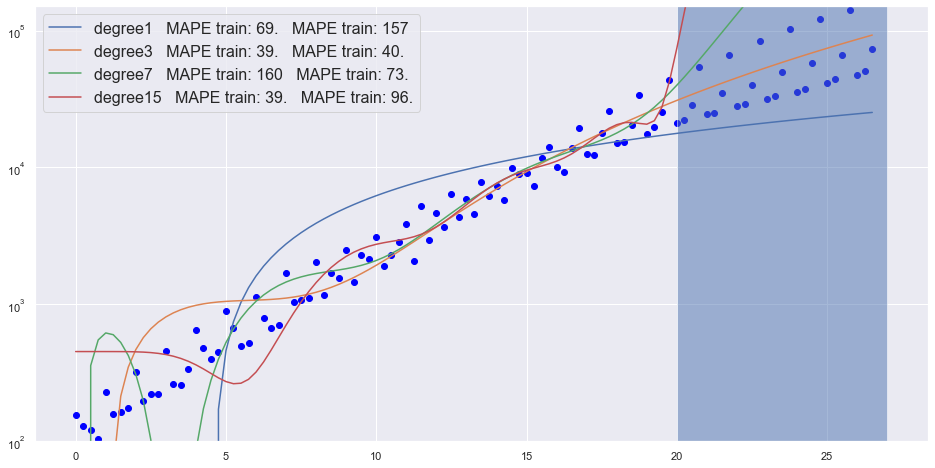

In [84]:
fig, axl = plt.subplots(1, 1)
axl.scatter(np.arange(len(y))/4, y, color='blue')
axl.axvspan((len(y) - test_points - 1)/4, len(y)/4 ,facecolor='b', alpha=0.5)

degree=2
for degree in [1, 3, 7, 15]:
    trained_model = polynomial_regression(degree).fit(X_train, y_train)
    y_hat_insample = trained_model.predict(X_train)
    y_hat_test = trained_model.predict(X_test)

    X_plot = np.concatenate((X_train, X_test), axis=None)
    Y_plot = np.concatenate((y_hat_insample, y_hat_test), axis=None)

    axl.plot(X_plot, Y_plot, label='degree{0}'.format(degree) +
             '   MAPE train: ' + str(mean_absolute_percentage_error(y_hat_insample, y_train))[0:3]
             + '   MAPE train: ' + str(mean_absolute_percentage_error(y_hat_test, y_test))[0:3]
            )

axl.set_ylim(100, 150000)
axl.set_yscale('log')
axl.legend(loc='best', prop={'size':16});

In [78]:
len(y)/4

156.0